# Interest Rate Swaps and Swaptions - Lesson 6

## Overview 

Last week we looked at how to extract ('bootstrap' or 'calibrate') a discount curve from observed market quotes.
This week we're going to move on using that discount curve to price EURIBOR/LIBOR interest rate swaps and swaptions.

## EONIA vs EURIBOR

Let's start by reminding ourselves of the differences and similarities between the EONIA/OIS and EURIBOR/LIBOR interest rate markets.

* Similarities:
    * both are **unsecured** lending, i.e. the lender assumes the risk of losing the capital if the borrower fails during the lending period;
    * both represent some kind of *average* interest rate between similar, large financial institutions.

* Differences:
    * EONIA/OIS:
        * are related to overnight lending, which needs to be renewed each day. This means that each day the lender can choose to not renew the loan or lend the capital to a different borrower;
        * rates are a volume-weighted average of real transactions.
    * EURIBOR/LIBOR:
        * refer to term lending, i.e. lending periods such as one month, three months, etc. The lender needs to wait until the expiration of the loan before having the option to lend the capital to a different borrower;
        * are determined through a survey of panel banks' percieved market rates.

A naive understanding of the interest rate markets would lead one to believe that these different markets (O/N, 1M, 3M, etc) can all be priced with a single discount curve - indeed in periods of low market stress, this has been the case.

In reality, the details of the liquidity and counterparty risk involved in each type of transaction are such that there is a basis between these markets, and therefore each one has a different discount (or rate) curve associated with it.

Given the fact that LIBOR curves do not represent a *pure* interest rate market but incorporate elements of liquidity and counterparty risk, it is surprising that, so many years after the financial crisis, they still maintain so much importance as benchmark rate markets for a wide range of purposes.

Indeed, though OIS markets are fully liquid enough to extract information about forward interest rates, there is no functioning options market from which to extract information about the volatility of those interest rates. The liquidity in rate volatility continues to be present only in the LIBOR swaptions markets.

As such, it continues to be important for banks to be able to price and calibrate market parameters against LIBOR instruments.



## Structure of today's lesson

* We'll start writing a class which represents and interest rate swap (IRS) on a LIBOR index. The class will have a method which, given a discount curve and a forward rate curve, will calculate the NPV of the swap (the latter curve will be used for determining the forward rates to calculate the expected value of the floating leg cash flows, whereas the former curve will be used to discount both the floating and fixed leg cash flows).

* Next we'll write a similar class for interest rate swaptions. We'll add a method for calculating the NPV analytically using the Black-Scholes formula, and then an additional method for calculating the same NPV via a Monte-Carlo simulation.

## Interest Rate Swaps

Interest rate swaps consist of a floating leg and a fixed leg. The contract parameters are:

* start date $d_0$
* notional $N$
* fixed rate $K$
* floating rate tenor (months)
* maturity (years)

The floating leg pays the reference LIBOR fixing at a frequency equal to the tenor of the floating rate - so for example an IRS on a 3-month LIBOR will pay a floating coupon every three months, an IRS on 6-month EURIBOR pays the floating coupon every six months and so on.

The fixed leg pays a predetermined cash flow at annual frequency, regardless of the tenor of  the underlying floating rate. For simplicity we will only consider swaps with maturities which are multiples of 1 year.

We can modify the `generate_swap_dates` function in `finmarkets.py` to generate the payment dates for both the fixed and floating legs, as follows:

In [1]:
from datetime import date
from dateutil.relativedelta import relativedelta

def generate_swap_dates(start_date, n_months, tenor_months=12):
    dates = []
    for n in range(0, n_months, tenor_months):
        dates.append(start_date + relativedelta(months=n))
    dates.append(start_date + relativedelta(months=n_months))
    return dates

generate_swap_dates(date.today(), 16, 3)

[datetime.date(2019, 10, 28),
 datetime.date(2020, 1, 28),
 datetime.date(2020, 4, 28),
 datetime.date(2020, 7, 28),
 datetime.date(2020, 10, 28),
 datetime.date(2021, 1, 28),
 datetime.date(2021, 2, 28)]

Using this function and the contract parameters we can determine a sequence of payment dates for each of the two legs.

Let $d_0=d_0^{\mathrm{fixed}},...,d_p^{\mathrm{fixed}}$ be the fixed leg payment dates and $d_0=d_0^{\mathrm{float}},...,d_p^{\mathrm{float}}$ be the floating leg payment dates, and let's use the following notation:
* $d$ the pricing date
* $D(d, d')$ the discount factor observed in date $d$ for the value date $d'$
* $F(d, d', d'')$ the forward rate observed in date $d$ for the period $[d', d'']$. The rate tenor is $\tau = d'' - d'$.

Then NPV of the fixed leg is calculated as follows:

$$\mathrm{NPV}_{\mathrm{fixed}}(d; K) = N\cdot K\cdot\sum_{i=1}^{p}D(d, d_{i}^{\mathrm{fixed}})$$

and the NPV of the floating leg is calculated as follows:

$$\mathrm{NPV}_{\mathrm{float}}(d) = N\cdot\sum_{i=1}^{q}F(d, d_{j-1}^{\mathrm{float}}, d_{j}^{\mathrm{float}}) \cdot \frac{d_{j}^{\mathrm{float}}-d_{j-1}^{\mathrm{float}}}{360}
\cdot D(d, d_{i}^{\mathrm{float}})$$

Therefore the NPV of the swap (seen from the point of view of the counterparty which receives the floating leg) is

$$\mathrm{NPV}(d; K) = \mathrm{NPV}_{\mathrm{float}}(d) - \mathrm{NPV}_{\mathrm{fixed}}(d;K)$$

For reasons which will become apparent later, it's actually more convenient to express the NPV of an IRS as a function of the fair value fixed rate $S$ of the IRS, also known as the swap rate. $S$ is the value of K which makes $\mathrm{NPV}(d)=0$.

On the basis of the previous expressions, we can easiy calculate $S$ as:

$$\mathrm{NPV}_{\mathrm{fixed}}(d;S) = \mathrm{NPV}_{\mathrm{float}}(d)$$
<br>
$$N\cdot S\cdot\sum_{i=1}^{p}D(d, d_{i}^{\mathrm{fixed}}) = N\cdot\sum_{i=1}^{q}F(d, d_{j-1}^{\mathrm{float}}, d_{j}^{\mathrm{float}}) \cdot \frac{d_{j}^{\mathrm{float}}-d_{j-1}^{\mathrm{float}}}{360} \cdot D(d, d_{i}^{\mathrm{float}})$$
<br>
$$S=\frac{\sum_{i=1}^{q}F(d, d_{j-1}^{\mathrm{float}}, d_{j}^{\mathrm{float}}) \cdot \frac{d_{j}^{\mathrm{float}}-d_{j-1}^{\mathrm{float}}}{360}
\cdot D(d, d_{i}^{\mathrm{float}})}{\sum_{i=1}^{p}D(d, d_i^{\mathrm{fixed}})} $$

Once we have calculated $S$, we can express the $\mathrm{NPV}$ of an IRS as follows:

$$\begin{align}&\mathrm{NPV}(d; K) = \mathrm{NPV}_{\mathrm{float}}(d) - \mathrm{NPV}_{\mathrm{fixed}}(d; K) = & \\ \\ &= \underbrace{\mathrm{NPV}_{\mathrm{float}}(d) - \mathrm{NPV}_{\mathrm{fixed}}(d; S)}_{\mathrm{=\;0}} + \mathrm{NPV}_{\mathrm{fixed}}(d;S) - \mathrm{NPV}_{\mathrm{fixed}}(d;K) & \\ & = N\cdot(S-K)\cdot\underbrace{\sum_{i=1}^{p}D(d, d_{i}^{\mathrm{fixed}})}_{\mathrm{'annuity'}}\end{align}$$

For convenience the relevant inputs that will be used later (observation date, discount and libor curve definitions) have been saved in a file `curve_data.py`.

In [2]:
from datetime import date
from curve_data import pricing_date, discount_curve, libor_curve
print(discount_curve.df(date(2020, 1, 1)))
print (libor_curve.forward_rate(date(2020, 1, 1)))

1.0003778376026289
0.01000266393442623


In [3]:
from finmarkets import generate_swap_dates

class InterestRateSwap:
    
    def __init__(self, start_date, notional, fixed_rate, tenor_months, 
                 maturity_years):
        self.notional = notional
        self.fixed_rate = fixed_rate
        self.fixed_leg_dates = \
            generate_swap_dates(start_date, 12 * maturity_years)
        self.floating_leg_dates = \
            generate_swap_dates(start_date, 12 * maturity_years,
                                                      tenor_months)
        
    def annuity(self, discount_curve):
        a = 0
        for i in range(1, len(self.fixed_leg_dates)):
            a += discount_curve.df(self.fixed_leg_dates[i])
        return a

    def swap_rate(self, discount_curve, libor_curve):
        s = 0
        for j in range(1, len(self.floating_leg_dates)):
            F = libor_curve.forward_rate(self.floating_leg_dates[j-1])
            tau = (self.floating_leg_dates[j] - \
                   self.floating_leg_dates[j-1]).days / 360
            P = discount_curve.df(self.floating_leg_dates[j])
            s += F * tau * P
        return s / self.annuity(discount_curve)
        
    def npv(self, discount_curve, libor_curve):
        S = self.swap_rate(discount_curve, libor_curve)
        A = self.annuity(discount_curve)
        return self.notional * (S - self.fixed_rate) * A

In [4]:
irs = InterestRateSwap(pricing_date, 1e6, 0.05, 6, 4)
irs.npv(discount_curve, libor_curve)

-160130.58128473637

#### Can you guess what could be the swap rate given that the npv is negative ? (Remember that we are looking at this contracts from the point of view of the receiver of the floating leg...)

In [5]:
irs.swap_rate(discount_curve, libor_curve)

0.010254255993254184

In [6]:
irs2 = InterestRateSwap(pricing_date, 1e6, 0.0102542, 6, 4)
irs2.npv(discount_curve, libor_curve)

0.2255897471446154

## Interest Rate Swaptions

Swaptions are the equivalent of European options for the interest rate markets. They give the option holder the right but not the obligation, at the exercise date $d_{ex}$, to enter into an IRS at a pre-determined fixed rate.

Clearly the option holder will only choose to do this if the NPV of the underlying swap at $d_{ex}$ is positive - looking at the expression for the NPV of the IRS in terms of the swap rate $S$ therefore, we can see that the payoff of the swaption is

$$N\cdot \mathrm{max}(0, S(d_{\mathrm{ex}}) - K)\cdot\sum D(d_{\mathrm{ex}}, d_i^{\mathrm{fixed}})$$

We now evaluate the NPV of a swaption in two alternative approaches.

#### Evaluation through Black-Scholes formula

In this case, to evaluate the NPV of this payoff, we'll use a generalization of the Black-Scholes-Merton formula applied to swaptions:

$$\mathrm{NPV} = N\cdot A\cdot [S \Phi(d_+) - K\Phi(d_-)]$$

where 

$$d_{\pm} = \frac{\mathrm{log}(\frac{S}{K}) \pm \frac{1}{2}\sigma^{2}T}{\sigma\sqrt{T}}\;\; (\sigma\;\textrm{is the volatility of the swap rate})$$
$$\\$$
$$A=\sum_{i=1}^{p}D(d, d_{i}^{\mathrm{fixed}}) \; (\mathrm{annuity})$$

In [7]:
sigma = 0.07
irs = InterestRateSwap(pricing_date, 1e6, 0.01, 6, 4)

from curve_data import pricing_date, discount_curve, libor_curve, start_date
from scipy.stats import norm 
import math
from dateutil.relativedelta import relativedelta

exercise_date = start_date + relativedelta(years=4)
A = irs.annuity(discount_curve)
S = irs.swap_rate(discount_curve, libor_curve)
T = (exercise_date - pricing_date).days / 365
d1 = (math.log(S/irs.fixed_rate) + 0.5 * sigma**2 * T) / (sigma * T**0.5)
d2 = (math.log(S/irs.fixed_rate) - 0.5 * sigma**2 * T) / (sigma * T**0.5)
npv = irs.notional * A * (S * norm.cdf(d1) - irs.fixed_rate * norm.cdf(d2))

print("Swaption NPV: {:.3f} EUR".format(npv))

Swaption NPV: 3330.741 EUR


### What's Monte Carlo Simulation ?

The modern version of the Monte Carlo method was invented in the late 1940s by Stanislaw Ulam, while he was working on nuclear weapons projects at the Los Alamos National Laboratory. 

Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle. Monte Carlo methods are mainly used in three problem classes: optimization, numerical integration, and generating draws from a probability distribution. 

In principle, Monte Carlo methods can be used to solve any problem having a probabilistic interpretation. By the law of large numbers, the expected value of some random variable can be approximated by taking the empirical mean of independent samples of the variable. 

Monte Carlo methods vary, but tend to follow a particular pattern:

* define a domain of possible inputs;
* generate inputs randomly from a probability distribution over the domain of inputs;
* perform a deterministic computation on the inputs;
* aggregate the results.

Monte Carlo simulation is widely used in many fields: Engineering,
Physics, Computational biology, Computer graphics, Applied statistics,
Artificial intelligence for games, Search and rescue and of course
Finance and business.

#### Pseudo-Random Numbers
Uses of Monte Carlo methods require large amounts of random numbers to generate the inputs, and it was their use that spurred the development of pseudorandom number generators. Every language has libraries that allows to produce huge series of random numbers (with a periodicity of $2^{19937}$).
Those numbers are produced by algorithms that take as inputs a *seed* which determines univokely the serie. This means that setting the same seed you will produce the same set of numbers every time which is great for debugging purpouses.

In Python the right module to use is `random` which has the following useful functions:

* `seed` set the seed of the random number generator;
* `random` returns a random number between 0 and 1;
* `randint(min, max)` returns an integer random number between `min` and `max` (uniform probability);
* `sample(aList, k=n)` samples n elements from a the list `aList`.

For a more detailed description check `help(random)`.

In [8]:
import random 

random.seed(1)
print ("seed is 1")
print(random.random())
print(random.random())
random.seed(2)

print ("seed is 2")
print(random.random())
print(random.random())
random.seed(1)

print ("seed is 1 again")
print(random.random())
print(random.random())

print(random.randint(1, 10))
aList = ['a', 'b', 'c', 'd', 'f']
print (random.sample(aList, k=2))

seed is 1
0.13436424411240122
0.8474337369372327
seed is 2
0.9560342718892494
0.9478274870593494
seed is 1 again
0.13436424411240122
0.8474337369372327
2
['c', 'a']


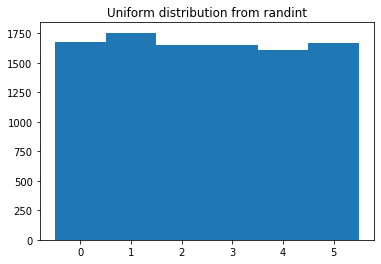

In [10]:

numbers = []
for _ in range(10000):
  numbers.append(random.randint(0, 5))

from matplotlib import pyplot as plt
plt.hist(numbers, 6, range=[-0.5, 5.5])
plt.title("Uniform distribution from randint")
plt.show()

#### Example

Let's try to check the probability to get two kings drawing two cards from a deck.
Using a frequentist approach, we can calculate the probability of an event as the ratio of the number of favorable outcomes of an experiment (number of successes) and the number of all possible outcomes so:

$$P_\textrm{two kings} = \frac{4}{40} \cdot \frac{3}{39} = \frac{1}{130} \approx 0.0077$$

Let's try with a Monte Carlo simulation.

In [11]:
from random import sample, choices, seed

seed(1)

deck = ["A", "2", "3", "4", "5", "6", "7", "J", "Q", "K"] * 4

trials = 1000000
success = 0

for i in range(trials):
  cards = sample(deck, k=2)
  if i < 10:
    print (cards)
  if cards == ["K", "K"]:
    success += 1
    
print ("The probability to draw two kings is {:.4f}".format(success/trials))

['Q', '7']
['5', '7']
['J', '2']
['Q', 'A']
['5', '4']
['7', '2']
['2', '5']
['J', 'Q']
['A', 'Q']
['J', '5']
The probability to draw two kings is 0.0077


Other modules provide random generators according to different distributions. Below an example with numpy.random which allows to throw random numbers according to a normal distribution ($\mathcal{N}(0, 1)$).

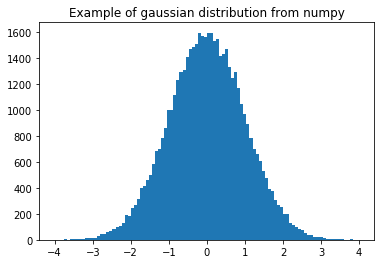

In [12]:
from numpy.random import normal
from matplotlib import pyplot as plt

gauss = []
for _ in range(50000):
  gauss.append(normal())
  
plt.hist(gauss, 100, range=[-4, 4])
plt.title("Example of gaussian distribution from numpy")
plt.show()

#### Derivation of log-normal Stochastic Differential Equation

Stock prices deviate from a steady state as a result of the random fluctuations given by the trades. Considering a stoke with a price $S_t$ and an expected rate of return $\mu$, then the relative change in its price during a period $dt$ can be decomposed in two parts:

* a deterministic part that is the expected return from the stock hold during the time period $dt$ ($\mu S_tdt$)
* a stochastic part which reflects the random changes in stock price (e.g. as a response to external effects such as unexpected news). A reasonable assumption is to take this contribution proportional to the stock ($\sigma S_tdB_t$ where $dB_t$ is a random walk process).

The resulting differential equation is:

$$dS_t = \mu S_tdt + \sigma S_tdB_t$$
or
$$\frac{dS_t}{S_t} = d\textrm{log}(dS_t) = \mu dt + \sigma dB_t$$

The solution of this equation can be derived by applying the It$\hat{o}$'s formula which states that for any given function $G(S, t)$ where $S$ satisfies the following stochastic differential equation $dS=a\cdot dt +b\cdot dB_t$ it holds:

$$dG=\big(a\frac{\partial G}{\partial S} + \frac{\partial G}{\partial t} + \frac{1}{2}b^2\frac{\partial^2 G}{\partial S^2} \big)dt + b \frac{\partial G}{\partial S}dB$$

Considering $G = \textrm{log}(S_t)$ we have:

$$\frac{\partial G}{\partial S} = \frac{1}{S_t}$$

$$\frac{\partial G}{\partial t} = 0$$

$$\frac{\partial^2 G}{\partial S^2} = -\frac{1}{S_t^{2}}$$

By inserting these into It$\hat{o}$'s formula we get:

$$d(\textrm{log} S_t) = \big(\mu S_t \frac{1}{S_t} + \frac{1}{2}\sigma^2 S_t^2 (-\frac{1}{S_t^2})\big)dt + \sigma\epsilon\sqrt{dt}$$

$$d(\textrm{log} S_t) = \textrm{log} (S_t) - \textrm{log} (S_{t-1}) = \textrm{log} \frac{S_t}{S_{t-1}} = \big(\mu - \frac{1}{2}\sigma^2\big)dt + \sigma\epsilon\sqrt{dt}$$

$$S_t = S_{t-1}e^{\big(\mu - \frac{1}{2}\sigma^2\big)dt + \sigma\epsilon\sqrt{dt}}$$

#### Evaluation through Monte-Carlo Simulation

In this second case we start from the current swap rate $S(d)$ evaluated at the pricing data $d$, and assume that it follows a log-normal stochastic process, so its distribution at $d_{\mathrm{ex}}$ (exercise date) is $S(d_{\mathrm{ex}}) = S(d)\mathrm{exp}\{-\frac{1}{2}\sigma^{2}T+\sigma\sqrt{T}\epsilon\}$ where $\epsilon\approx\mathcal{N}(0,1)$. 
To perform the simulation:

* we sample the normal distribution $\mathcal{N}$ to calculate a large number of scenarios for $S(d_{\mathrm{ex}})$;
* we evaluate the underlying swap's NPV at the expiry date, and consequently the swaption's payoff, and take the average of these values.

In [14]:
# we'll need numpy.mean and numpy.std to calculate the average and standard 
# deviation of a list of values
import numpy as np
from numpy.random import normal, seed

# define the number of Monte Carlo scenarios
n_scenarios = 50000
discounted_payoffs = []
seed(1)

for i_scenario in range(n_scenarios):
    # simulate the swap rate in this scenario
    S_simulated = S * math.exp(-0.5 * sigma * sigma * T +
                               sigma * math.sqrt(T) * normal())
    
    # calculate the swap NPV in this scenario
    swap_npv = irs.notional * (S_simulated - irs.fixed_rate) * A
    
    # add the discounted payoff of the swaption, in this scenario, to the list
    discounted_payoffs.append(max(0, swap_npv))
    
    # calculate the NPV of the swaption by taking the average of the discounted 
    # payoffs across all the scenarios
    npv_mc = np.mean(discounted_payoffs)
    
# calculate the Monte Carlo error estimate for 'npv_mc' this will give us a 99% 
# confidence interval for the calculated value (3 sigmas)
npv_error = 3 * np.std(discounted_payoffs) / math.sqrt(n_scenarios)

print("Swaption NPV: {:.2f} EUR (+/‐ {:.2f} EUR with 99% confidence)"\
      .format(npv_mc, npv_error))

Swaption NPV: 3351.42 EUR (+/‐ 66.14 EUR with 99% confidence)


In [15]:
# Note that this is not *strictly speaking* the correct way of calculating
# the value, the reason being that one should calculate the swap NPV at 
# the expiry date of the swaption, apply the payoff function max(0, ...) 
# and *then* discount from the expiry date to today.

# However, it's simpler to calculate it as above and it doesn't make any 
# difference to the result, since 
# DF * max(0, SwapNPVAtExpiry) == max(0, DF * SwapNPVAtExpiry)

The NPV calculated via the Black-Scholes-Merton formula falls within the confidence interval produced by the Monte Carlo simulation, so we can assert that the two methods are in agreement.

* Swaption NPV (BS): 3330.74 EUR
* Swaption NPV (MC): 3351.42 EUR

#### Confidence interval
X% confidence interval can be interpreted by saying that there is X% probability that the calculated interval from another (different) simulation contains the true value of the population parameter. In other words X% confidence interval can be expressed in terms of repeated experiments (or samples): if you repeat many time the above simulation, hence $\mathcal{N}$ is sampled many times, the fraction of calculated confidence intervals (which would differ for each sample) than contains the true population parameter would tend toward X%

![Confidence interval graphical explanation](Standard_deviation_diagram.svg.png)

## Exercises

### Exercise 6.1

Write a ForwardRateCurve (for EURIBOR/LIBOR rate curve) which doesn't compute discount factors but only interplatates forward rates; then add it to the `finmarkets` module.


### Exercise 6.2
Using the function `randint` of the module `random` make a Monte Carlo simulation of rolling three dices to check the probability of getting the same values on the three of them.

From the probability theory you should expect:

$$P_{d1=d2=d3} = \frac{1}{6}\cdot\frac{1}{6}\cdot\frac{1}{6}\cdot 6 = \frac{1}{36} = 0.0278$$

### Exercise 6.3
Using the function `normal` of `numpy.random` simulate the price of a stoke which evolves according to a log-normal stochastic process with a daily rate of return $\mu=0.1$ and a volatility $\sigma=0.15$ for 30 days.

Also plot the price. Try to play with $\mu$ and $\sigma$ to see how the plot changes.

### Exercise 6.4
Suppouse that the Libor Forward rates are those defined here in $\href{https://repl.it/@MatteoSani/support6}{curve\_data.py}$. Determine the value of an option to pay a fixed rate of 4% and receives LIBOR on a 5 year swap starting in 1 year. Assume the  notional is 100 EUR, the exercise date is on October, 30th 2020 and the swap rate volatility is 15%.